In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision import models
import timm
import csv
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy
import random
from torch.optim.lr_scheduler import StepLR, MultiStepLR, LambdaLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torchsummary import summary

In [26]:
# 设置随机数种子，保证结果的可重复性
random.seed(2024)
np.random.seed(2024)
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)

In [27]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load pretrained Swin Transformer model
# model = models.resnet50(pretrained=False)

# 无预训练
model = models.resnet50()

# print(model)
# for name, module in model.named_modules():
#     # if name == 'norm' or name == 'head':
#     print(name)
# model
# summary(model, (3, 224, 224))

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [28]:
# 假设你的权重文件路径是'path_to_your_weights.pth'
#weights_path = 'root/autodl-tmp/project/MedSAM-0.1/Resnet/01.pth'

# 加载权重
#model.load_state_dict(torch.load(weights_path))
num_ftrs = model.fc.in_features 
for param in model.parameters():
    param.requires_grad = False #False：冻结模型的参数，也就是采用该模型已经训练好的原始参数。只需要训练我们自己定义的Linear层
 
#保持in_features不变，修改out_features=3
model.fc = nn.Sequential(nn.Linear(num_ftrs,6),
                            nn.LogSoftmax(dim=1))

In [ ]:
all_layer_names = [name for name, _ in model.named_parameters()] # model.named_modules() model.named_parameters()
free_layer_names = all_layer_names[:]#[-20:]
free_layer_names

In [32]:
import torch
from timm.models import create_model

num_params = sum(p.numel() for p in model.parameters()) # 模型的参数个数
print(f"Number of parameters in resnet50 model: {num_params}")


Number of parameters in resnet50 model: 23520326


In [34]:
# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 调整形状
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # 转成tensor格式
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

In [35]:

# transform = None
data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/MULTI_TUMOR_split" # 数据存储的根目录

train_data = datasets.ImageFolder(os.path.join(data_dir, "train")) # 对训练数据做增强，增加LGG类型的数量
# train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform) # 不对训练数据做增强，使用focal loss解决不平衡问题
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# train_data = train_loader.dataset[:1000]

# 从训练集中划分0.2作为验证集
# 划分训练集和验证集
# val_size = int(0.2 * len(train_data))
# train_size = len(train_data) - val_size

# val_size = 1000
# train_size = 6000
# other_size = len(train_data) - train_size - val_size
# print(train_size, val_size)
# train_data, val_data = random_split(train_data, [train_size, val_size])
# train_data, val_data, _ = random_split(train_data, [train_size, val_size, other_size]) # 训练数据集切分成训练集和验证集
# print(len(train_data))
batch_size=64
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=64)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=64)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=64)

In [37]:
len(train_data), len(val_data), len(test_data), len(augmented_dataset)
# len(train_data), len(test_data)

(1242, 154, 158, 1242)

In [38]:
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(augmented_dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())
    # print(labels)
    # break

In [39]:
targets.count(1), targets.count(0)

(276, 371)

In [40]:
# 

In [42]:
# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(modal ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'Acc_curve_of_' + modal + '.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'Auc_curve_of_' + modal + '.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'F1_curve_of_' + modal + '.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'Recall_curve_of_' + modal + '.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./inde_train_curve_images/' + 'ROC_curve_of_' + modal + '.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG', 'normal']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./inde_val_confusion_martix_figs/' + 'Confusion_martix_of_' + modal + '.png')
    # plt.show()
    plt.close()

In [43]:
# Set loss function and optimizer
# 训练 验证 测试 基于scan划分，独立测试

# 迁移训练的层的设置
flair_model = copy.deepcopy(model) # 不同输入的模型结果需要分开存储
flair_model.to(device)
flair_params_to_update = [] # 需要更新的层

# 只更新部分层
for name, param in flair_model.named_parameters():
    # free后30层
    # if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
    #     param.requires_grad = False
    # if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
    #     param.requires_grad = False
    # else: # 后30层网络需要训练
    #     param.requires_grad = True # 手动设置，不然不会自动赋值
    #     flair_params_to_update.append(param)  
    
    # free后2层
    # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
    if name not in free_layer_names: # 只训练最后几层
        param.requires_grad = False 
    else:
        param.requires_grad = True # 手动设置，不然不会自动赋值
        flair_params_to_update.append(param)
        
        
# # 对需要更新的层，设置dropout防止过拟合
# new_dropout = 0.5  # 设置为0.5，即50%的Dropout
# # 遍历模型的参数，找到所有的Dropout层，并设置新的Dropout值
# for name, module in flair_model.named_modules():
#     # 修改后30层的dropout
#     if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
#         pass
#     if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
#         pass
#     else: # 后30层网络需要训练
#         if isinstance(module, nn.Dropout):
#             # print(name)
#             module.p = new_dropout
# flair_model
len(flair_params_to_update)

161

In [44]:
criterion = nn.CrossEntropyLoss()
alpha = torch.tensor([3.0, 1.0])
# print(type(alpha))
# criterion = FocalLoss(alpha=[3.0, 1.0], gamma=2) # 自定义的focal loss
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(flair_params_to_update, lr=5e-3)
# # 学习率动态变化
# dynamic_lr = CosineAnnealingLR(optimizer, T_max=10)
# print("初始化的学习率：",optimizer.defaults['lr'])

# lr_list = []
# for epoch in range(1,101):
#     optimizer.zero_grad()
#     optimizer.step()
#     print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
#     lr_list.append(optimizer.param_groups[0]['lr'])
#     dynamic_lr.step()
    
# #画出epoch的变化图
# plt.plot(list(range(1,101)),lr_list)
# plt.xlabel("epoch")
# plt.ylabel("lr")
# plt.title("learning rate curve !")
# plt.show()

In [45]:
# Training and validation
num_epochs = 500
train_acc_history = []
val_acc_history = []
val_auc_history = []
val_f1_history = []
val_r_history = []

min_loss = float('inf') # 初始min_loss无穷大
best_acc = 0.0
best_auc = 0.0
patience = 30 # patience原来设成80，设为30当连续20个epoch不再下降时，改变学习率
early_stop = patience
change_rate = 15 # 多少个epoch不发生提升时，改变学习率

for epoch in range(num_epochs):
    # Training
    flair_model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # 图像与标签
        optimizer.zero_grad()
        outputs = flair_model(images)
        
        loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
        # print(loss)
        loss.backward()
        optimizer.step()


        # _, predicted = torch.max(outputs, 1)
        predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    # 调整学习率, 一个epoch结束后调整学习率
    # print('current epoch lr:', optimizer.param_groups[0]['lr'])
    # dynamic_lr.step()
    lr = optimizer.param_groups[0]['lr'] # 当前epoch的学习率
    # 当early stop连续20次指标不再上升时，改变学习率
    if early_stop < (patience - change_rate):
        lr -= lr / (change_rate + early_stop)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print ('Decay learning rate to lr: {}.'.format(lr))
    
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)

    
    # Validation
    flair_model.eval()
    val_correct = 0
    val_total = 0
    val_outputs_list = []
    val_labels_list = []
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = flair_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1)
    
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_outputs_list.append(outputs.cpu().numpy())
            val_labels_list.append(labels.cpu().numpy())

        val_acc = val_correct / val_total
        val_acc_history.append(val_acc)

        val_outputs = np.concatenate(val_outputs_list, axis=0)
        val_labels = np.concatenate(val_labels_list, axis=0)

        val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
        val_auc = auc(val_fpr, val_tpr)
        val_auc_history.append(val_auc)

        val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
        val_f1_history.append(val_f1)

        val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
        val_r_history.append(val_r)

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        # 得到验证集的平均损失
        # 设置早停点
        # if min_loss > avg_val_loss:
        if best_acc < val_acc: # 以auc值最大存储最佳模型
            # min_loss = avg_val_loss
            best_acc = val_acc
            early_stop = patience
            model_name = 'flair_model_fml.pth' # 损失值最小的时候设置成最佳模型
            torch.save(flair_model.state_dict(), model_name)
        else: # 当前的平均损失比之前epoch的要大
            early_stop -= 1
        
        # 当early_stop为0时，结束epoch训练
        if early_stop == 0:
            break

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
        

plot_train_curve('flair', train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)

Epoch 1/500, Train Acc: 0.2593, Val Acc: 0.2468, Val AUC: 0.4066, Val F1: 0.1450, Val Recall: 0.2468, Val Loss: 953.5733, Early Stop: 30
Epoch 2/500, Train Acc: 0.4219, Val Acc: 0.2468, Val AUC: 0.7373, Val F1: 0.1588, Val Recall: 0.2468, Val Loss: 2.6308, Early Stop: 29
Epoch 3/500, Train Acc: 0.4694, Val Acc: 0.4026, Val AUC: 0.8110, Val F1: 0.3506, Val Recall: 0.4026, Val Loss: 1.8555, Early Stop: 30
Epoch 4/500, Train Acc: 0.5185, Val Acc: 0.3701, Val AUC: 0.7461, Val F1: 0.3531, Val Recall: 0.3701, Val Loss: 3.9298, Early Stop: 29
Epoch 5/500, Train Acc: 0.5346, Val Acc: 0.5065, Val AUC: 0.7755, Val F1: 0.4677, Val Recall: 0.5065, Val Loss: 1.5735, Early Stop: 30
Epoch 6/500, Train Acc: 0.5451, Val Acc: 0.3506, Val AUC: 0.7284, Val F1: 0.3203, Val Recall: 0.3506, Val Loss: 2.0048, Early Stop: 29
Epoch 7/500, Train Acc: 0.6337, Val Acc: 0.5974, Val AUC: 0.8480, Val F1: 0.5695, Val Recall: 0.5974, Val Loss: 1.2736, Early Stop: 30
Epoch 8/500, Train Acc: 0.6538, Val Acc: 0.5844, Val 

In [46]:
# torch.save(model.state_dict(), "swin_model_brat_cls_2024_4_21.pth") # 存储模型
flair_model.load_state_dict(torch.load("flair_model_fml.pth")) # 加载训练阶段存储的最佳模型

<All keys matched successfully>

In [47]:
# plot_train_curve('flair', train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)

In [48]:
plot_train_curve('flair', train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

In [50]:
# Create a data loader for the images
import torch.nn.functional as F
data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/MULTI_TUMOR_split/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = flair_model(images)
        probabilities = F.softmax(outputs, dim=1)  # 使用softmax函数进行概率化处理
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())
        y_scores.append(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.concatenate(y_scores, axis=0)

acc = accuracy_score(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_scores[:, 2], multi_class='ovo')
f1 = f1_score(y_true, y_pred,average='weighted')
recall = recall_score(y_true, y_pred,average='weighted')

print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")#AUC: {auc_score:.4f}, 

Accuracy: 0.9747, F1 Score: 0.9747, Recall: 0.9747


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.94      0.94      0.94        35
           2       0.96      0.96      0.96        28
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        16

    accuracy                           0.97       158
   macro avg       0.98      0.98      0.98       158
weighted avg       0.97      0.97      0.97       158



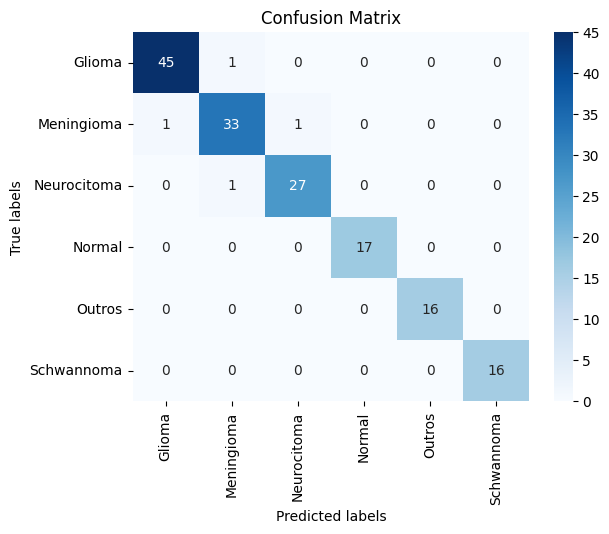

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define class labels
labels = ['Glioma','Meningioma', 'Neurocitoma', 'Normal', 'Outros', 'Schwannoma']  # 用您的实际类别标签替换...

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()